# fvGP Single-Task Test

In [1]:
#!pip install fvgp~=4.7.4

## Setup

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from fvgp import GP
import time
from distributed import Client
client = Client()

%load_ext autoreload
%autoreload 2

In [3]:
from itertools import product
x_pred1D = np.linspace(0,1,1000).reshape(-1,1)

## Data

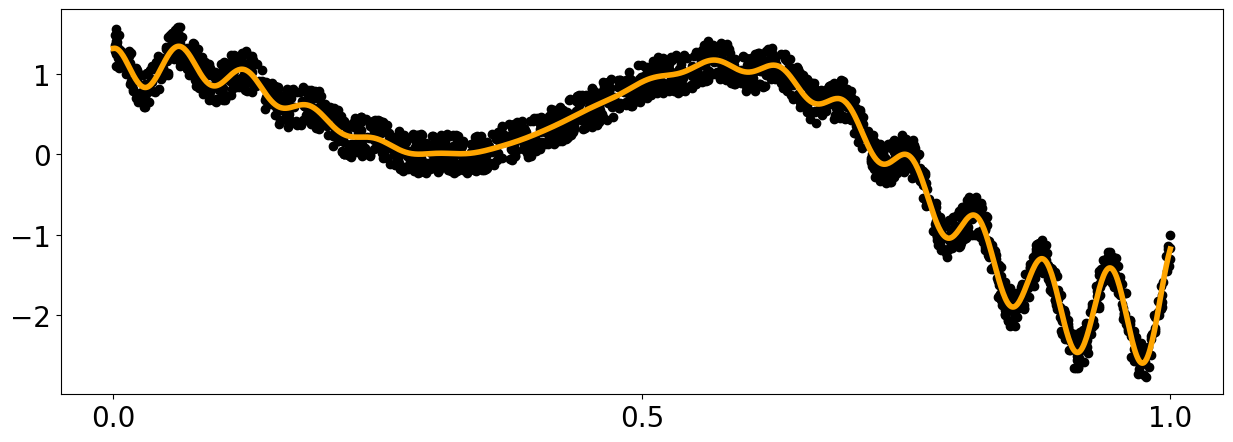

In [4]:
x = np.linspace(0,600,1000)
def f1(x):
    return np.sin(5. * x) + np.cos(10. * x) + (2.* (x-0.4)**2) * np.cos(100. * x)
#np.random.seed(42)
x_data = np.random.rand(2000).reshape(-1,1) 
y_data = f1(x_data[:,0]) + (np.random.rand(len(x_data))-0.5) * 0.5

plt.figure(figsize = (15,5))
plt.xticks([0.,0.5,1.0])
plt.yticks([-2,-1,0.,1])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.plot(x_pred1D,f1(x_pred1D), color = 'orange', linewidth = 4)
plt.scatter(x_data[:,0],y_data, color = 'black')

## Customizing a Gaussian Process

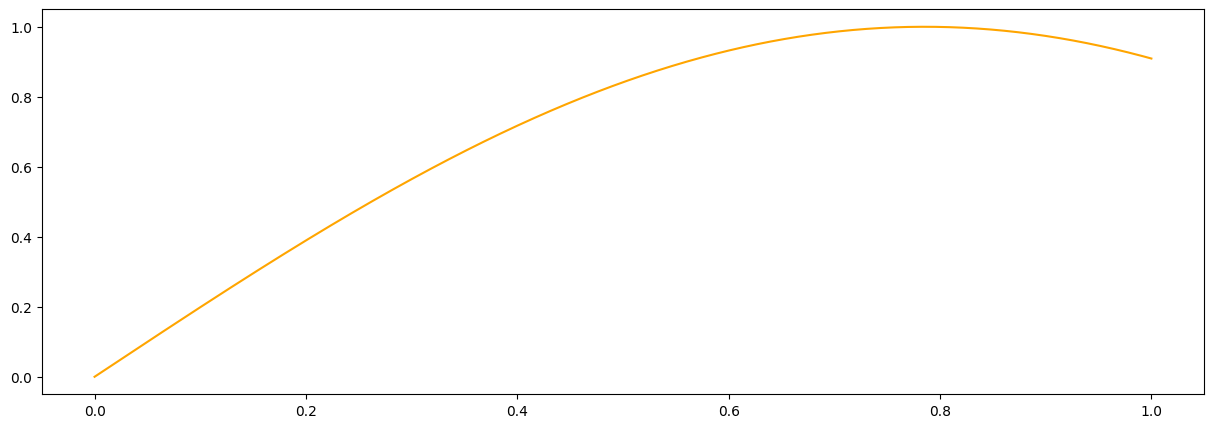

In [5]:
from fvgp.kernels import *
from scipy import sparse
def my_noise(x,hps):
    #This is a simple noise function, but can be arbitrarily complex using many hyperparameters.
    #The noise can be a vector, a matrix, or a sparse matrix in case gp2Scale is used.  
    return np.zeros(len(x)) + hps[2]

#stationary
def skernel(x1,x2,hps):
    #The kernel follows the mathematical definition of a kernel. This
    #means there is no limit to the variety of kernels you can define.
    d = get_distance_matrix(x1,x2)
    return hps[0] * matern_kernel_diff1(d,hps[1])


def meanf(x, hps):
    #This ios a simple mean function but it can be arbitrarily complex using many hyperparameters.
    return np.sin(hps[3] * x[:,0])
#it is a good idea to plot the prior mean function to make sure we did not mess up
plt.figure(figsize = (15,5))
plt.plot(x_pred1D,meanf(x_pred1D, np.array([1.,1.,5.0,2.])), color = 'orange', label = 'task1')

## Initialization and different training options

In [6]:
st = time.time()
from loguru import logger
logger.disable("fvgp")
my_gp1 = GP(x_data,y_data,
            init_hyperparameters = np.ones((4))/10.,  # we need enough of those for kernel, noise, and prior mean functions
            noise_variances=np.ones(y_data.shape) * 0.1, # providing noise variances and a noise function will raise a warning 
            compute_device='cpu', 
            kernel_function=skernel, 
            kernel_function_grad=None, 
            #prior_mean_function=meanf, 
            prior_mean_function_grad=None,
            #noise_function=my_noise,
            gp2Scale = False,
            calc_inv=False, 
            ram_economy=False,
            )


hps_bounds = np.array([[0.01,10.], #signal variance for the kernel
                       [0.01,10.], #length scale for the kernel
                       [0.001,0.1],  #noise
                       [0.01,1.]  #mean
                      ])
#my_gp1.update_gp_data(x_data, y_data, noise_variances_new=np.ones(y_data.shape) * 0.05) #this is just for testing, not needed
print("Standard Training (MCMC)")
my_gp1.train(hyperparameter_bounds=hps_bounds, info = True, max_iter = 100)
print(time.time() - st)
#print("Global Training")
#my_gp1.train(hyperparameter_bounds=hps_bounds, method='global', max_iter = 20)
#print("hps: ", my_gp1.hyperparameters)
#print("Local Training")
#my_gp1.train(hyperparameter_bounds=hps_bounds, method='local')
#print(my_gp1.hyperparameters)
#print("HGDL Training")
#print(my_gp1.hyperparameters)
#my_gp1.train(hyperparameter_bounds=hps_bounds, method='hgdl', max_iter=2, dask_client=client)


here we go now dfvdv
Standard Training (MCMC)
Finished  10  out of  100  MCMC iterations. f(x)=  -55.040719812541965
Finished  20  out of  100  MCMC iterations. f(x)=  -55.040719812541965
Finished  30  out of  100  MCMC iterations. f(x)=  -55.040719812541965
Finished  40  out of  100  MCMC iterations. f(x)=  -55.040719812541965
Finished  50  out of  100  MCMC iterations. f(x)=  -55.040719812541965
Finished  60  out of  100  MCMC iterations. f(x)=  78.9660845133235
Finished  70  out of  100  MCMC iterations. f(x)=  111.87205970918058
Finished  80  out of  100  MCMC iterations. f(x)=  111.15505472442919
Finished  90  out of  100  MCMC iterations. f(x)=  114.75999801250646
30.50668740272522


In [7]:
my_gp1.x_data.shape

(2000, 1)

### More advanced: Asynchronous training
Train asynchronously on a remote server or locally. 
You can also start a bunch of different training runs on different computers.
This training will continue without any signs of life until you query  the solution via 'update_hyperparameters(object)' or call 'my_gp1.stop_training(opt_obj)'

In [8]:
my_gp1.set_hyperparameters(np.array([1,1,1,1]))

In [9]:
opt_obj = my_gp1.train_async(hyperparameter_bounds=hps_bounds, dask_client=client)

In [10]:
# The result won't change much (or at all) since this is such a simple optimization
for i in range(200):
    time.sleep(1.)
    print("iteration ", i)
    my_gp1.update_hyperparameters(opt_obj)
    print(my_gp1.hyperparameters)

/home/marcus/VirtualEnvironments/fvgp_dev/lib/python3.11/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 61.12 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


iteration  0


/home/marcus/Coding/fvGP/fvgp/gp.py:764: UserWarning: Hyperparameter update not successful len(optima list) = 0
  res = self.trainer.update_hyperparameters(opt_obj)


[1 1 1 1]
iteration  1
[1 1 1 1]
iteration  2
[1 1 1 1]
iteration  3
[1 1 1 1]
iteration  4
[1 1 1 1]
iteration  5
[1 1 1 1]
iteration  6
[1 1 1 1]
iteration  7
[1 1 1 1]
iteration  8
[1 1 1 1]
iteration  9
[1 1 1 1]
iteration  10
[1 1 1 1]
iteration  11
[1 1 1 1]
iteration  12
[1 1 1 1]
iteration  13
[1 1 1 1]
iteration  14
[1 1 1 1]
iteration  15
[1 1 1 1]
iteration  16
[1 1 1 1]
iteration  17
[1 1 1 1]
iteration  18
[1 1 1 1]
iteration  19
[1 1 1 1]
iteration  20
[1 1 1 1]
iteration  21
[1 1 1 1]
iteration  22
[1 1 1 1]
iteration  23
[1 1 1 1]
iteration  24
[1 1 1 1]
iteration  25
[1 1 1 1]
iteration  26
[1 1 1 1]
iteration  27
[1 1 1 1]
iteration  28
[1 1 1 1]
iteration  29
[1 1 1 1]
iteration  30
[1 1 1 1]
iteration  31
[1 1 1 1]
iteration  32
[1 1 1 1]
iteration  33
[1 1 1 1]
iteration  34
[1 1 1 1]
iteration  35
[1 1 1 1]
iteration  36
[1 1 1 1]
iteration  37
[1 1 1 1]
iteration  38
[1 1 1 1]
iteration  39
[1 1 1 1]
iteration  40
[1 1 1 1]
iteration  41
[1 1 1 1]
iteration  42
[

In [11]:
my_gp1.update_hyperparameters(opt_obj)

array([0.94742661, 0.06912988, 0.04101062, 0.23790677])

In [12]:
my_gp1.stop_training(opt_obj) ##this leaves the dask client alive, kill_client() will shut it down. 

## The Result

In [13]:
my_gp1.hyperparameters
#DOES NOT WORK: array([0.80096475, 0.0662706 , 0.08988444, 0.25189999])
#DOES     WORK: array([0.84519429, 0.06890454, 0.09399283, 0.23367273])
my_gp1.set_hyperparameters(np.array([0.99060988, 0.07606013, 0.0993521 , 0.01268085]))

In [14]:
#print(my_gp1.m)
#print(my_gp1.V)

Posterior Mean and Uncertainty


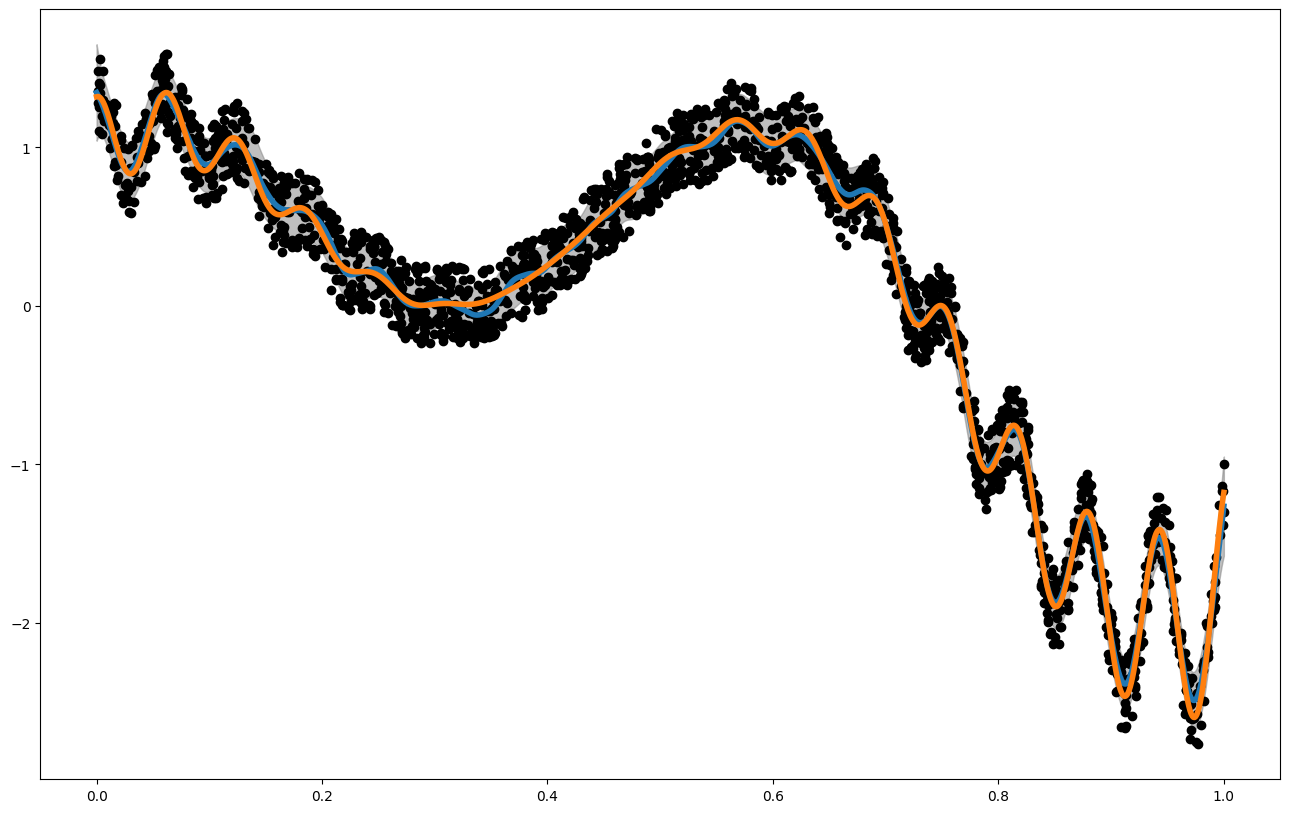

Posterior Mean Gradient


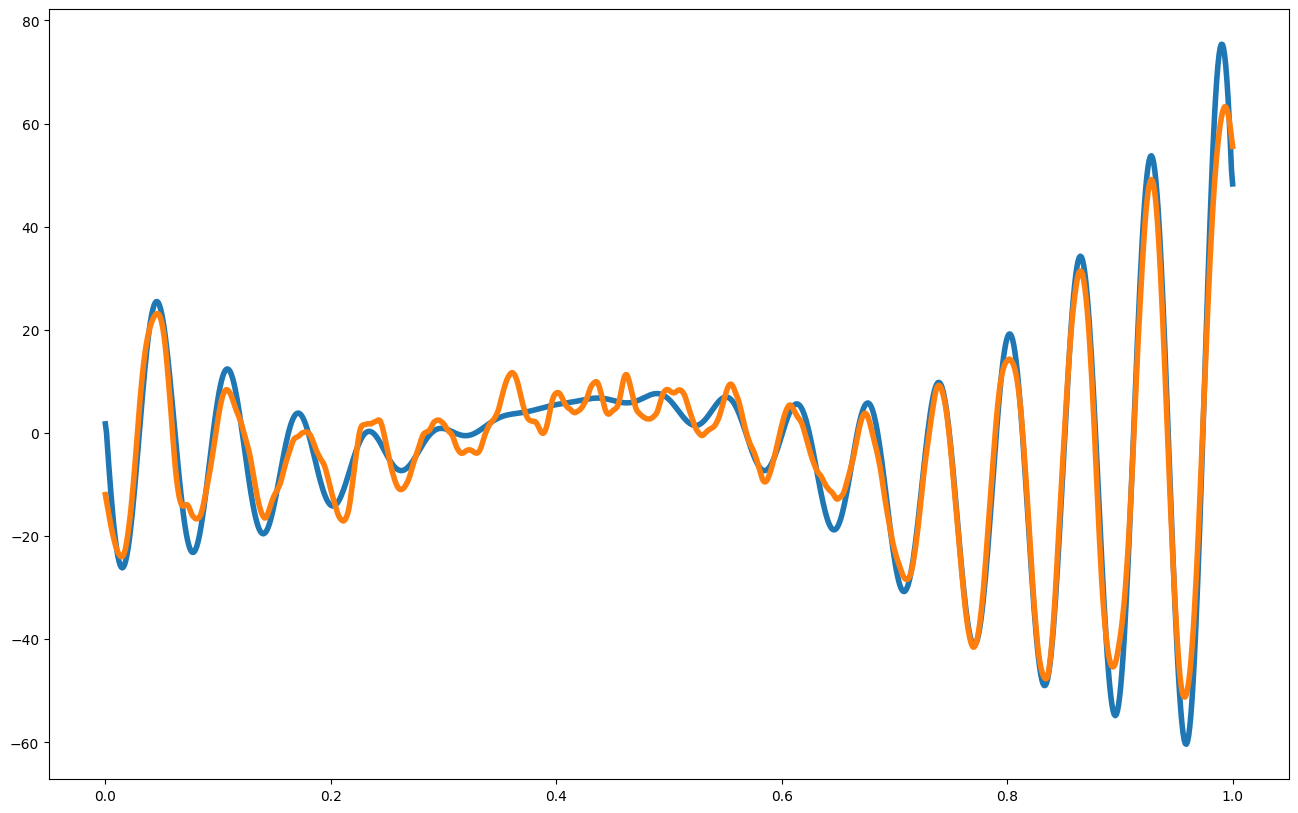

RMSE:              0.03550557190370242
CRPS (mean, std):  (np.float64(0.021164444630567086), np.float64(0.011288920212119887))
R2:                0.9988159147011055
NLPD:              -1.7693374582045855


In [15]:
#let's make a prediction
x_pred = np.linspace(0,1,1000)


# different ways to call 
var1 =  my_gp1.posterior_covariance(x_pred.reshape(-1,1), variance_only=False, add_noise=False)["v(x)"]
var1 =  my_gp1.posterior_covariance(x_pred.reshape(-1,1), variance_only=False, add_noise=True)["v(x)"]

mean1 = my_gp1.posterior_mean(x_pred.reshape(-1,1))["m(x)"]
var1 =  my_gp1.posterior_covariance(x_pred.reshape(-1,1), variance_only=False, add_noise=True)["v(x)"]
mean_grad = my_gp1.posterior_mean_grad(x_pred.reshape(-1,1), direction=0)["dm/dx"]

print("Posterior Mean and Uncertainty")
plt.figure(figsize = (16,10))
plt.plot(x_pred,mean1, label = "posterior mean", linewidth = 4)
plt.plot(x_pred1D,f1(x_pred1D), label = "latent function", linewidth = 4)
plt.fill_between(x_pred, mean1 - 3. * np.sqrt(var1), mean1 + 3. * np.sqrt(var1), alpha = 0.5, color = "grey", label = "var")
plt.scatter(my_gp1.x_data,my_gp1.y_data, color = 'black')
plt.show()

print("Posterior Mean Gradient")
plt.figure(figsize = (16,10))
dx = 1./len(x_pred)
plt.plot(x_pred1D,np.gradient(f1(x_pred1D).flatten(), dx), label = "ground truth gradient", linewidth = 4)
plt.plot(x_pred1D,mean_grad, label = "posterior mean grad", linewidth = 4)
plt.show()



##looking at some validation metrics
print("RMSE:             ",my_gp1.rmse(x_pred1D,f1(x_pred1D).flatten()))
print("CRPS (mean, std): ",my_gp1.crps(x_pred1D,f1(x_pred1D).flatten()))
print("R2:               ",my_gp1.r2(x_pred1D,f1(x_pred1D).flatten()))
print("NLPD:             ",my_gp1.nlpd(x_pred1D,f1(x_pred1D).flatten()))

## Predicted Information Gain

In [16]:
relative_entropy =  my_gp1.gp_relative_information_entropy_set(x_pred.reshape(-1,1))["RIE"]

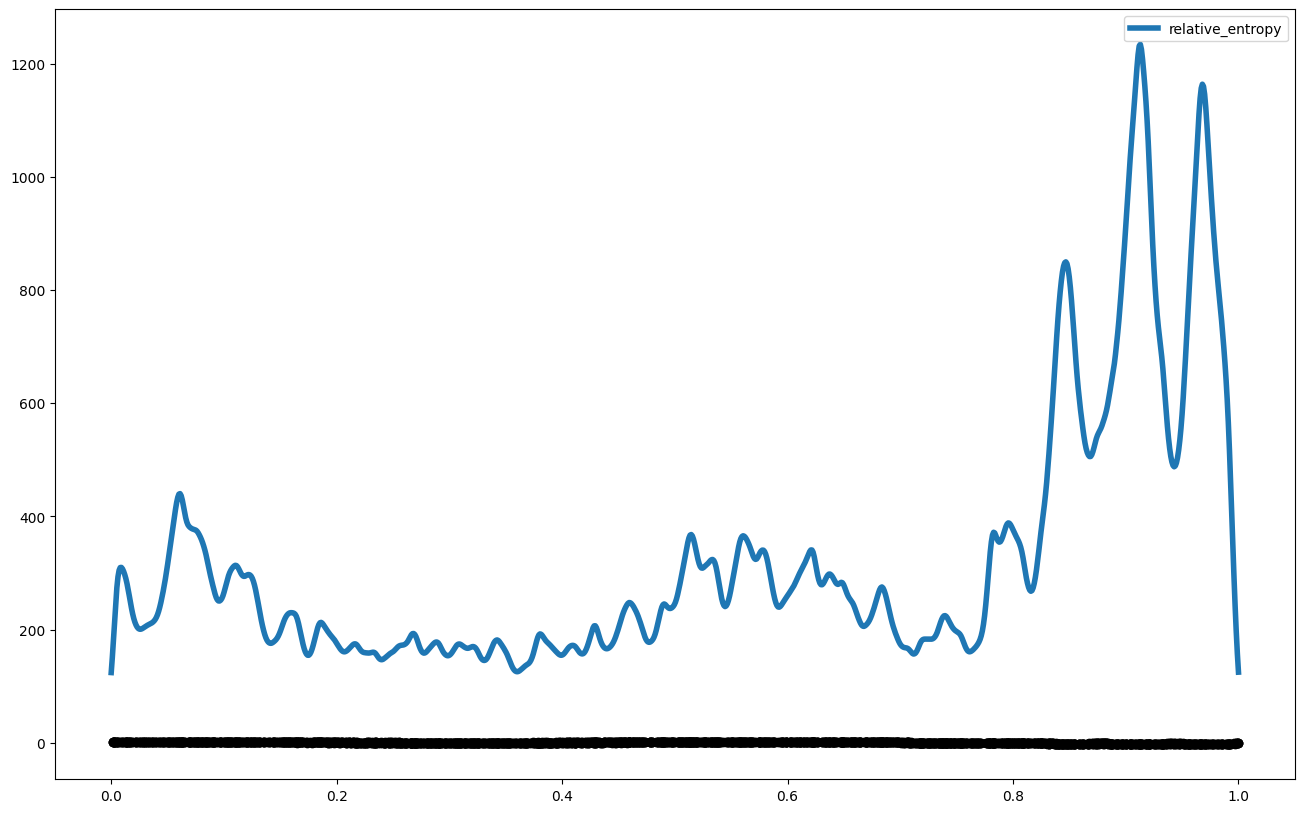

In [17]:
plt.figure(figsize = (16,10))
plt.plot(x_pred,relative_entropy, label = "relative_entropy", linewidth = 4)
plt.scatter(x_data,y_data, color = 'black')
plt.legend()

In [18]:
#We can ask mutual information and total correlation there is given some test data
x_test = np.array([[0.45],[0.45]])
print("MI: ",my_gp1.gp_mutual_information(x_test))
print("TC: ",my_gp1.gp_total_correlation(x_test))
my_gp1.gp_entropy(x_test)
my_gp1.gp_entropy_grad(x_test, 0)
my_gp1.gp_kl_div(x_test, np.ones((len(x_test))), np.identity((len(x_test))))
my_gp1.gp_relative_information_entropy(x_test)
my_gp1.gp_relative_information_entropy_set(x_test)
my_gp1.posterior_covariance(x_test)
my_gp1.posterior_covariance_grad(x_test)
my_gp1.posterior_mean(x_test)
my_gp1.posterior_mean_grad(x_test)
my_gp1.posterior_probability(x_test, np.ones((len(x_test))), np.identity((len(x_test))))

MI:  {'x': array([[0.45],
       [0.45]]), 'mutual information': np.float64(7.724099526672944)}
TC:  {'x': array([[0.45],
       [0.45]]), 'total correlation': np.float64(17.734441382913815)}


{'mu': array([0.56149345, 0.56149345]),
 'covariance': array([[0.00295941, 0.00295931],
        [0.00295931, 0.00295941]]),
 'probability': np.float64(0.13077484885997825)}